In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn

In [32]:
datapath = "/Users/whysocurious/Documents/MLDSAIProjects/cust-seg-case-study/data"
dfcust = pd.read_csv(datapath+'/customer_data_imputed.csv').set_index('Customer ID')
#(datapath+'/Customer Segmentation.csv')
print (f"Data shape: {dfcust.shape}")
print (f"Data columns: {dfcust.columns.tolist()}")
print (f"Data types:\n{dfcust.dtypes}")
print (f"Missing values:\n{dfcust.isnull().sum()}")
# dfcust.head()


Data shape: (8363, 8)
Data columns: ['Gender', 'Ever_Married', 'Age', 'Graduated', 'Profession', 'Work_Experience', 'Spending_Score', 'Family_Size']
Data types:
Gender              object
Ever_Married        object
Age                  int64
Graduated           object
Profession          object
Work_Experience    float64
Spending_Score      object
Family_Size        float64
dtype: object
Missing values:
Gender             0
Ever_Married       0
Age                0
Graduated          0
Profession         0
Work_Experience    0
Spending_Score     0
Family_Size        0
dtype: int64


In [33]:
hdbscan_clus = pd.read_csv(datapath+"/clus_hdbscan.csv")
kmeans_clus = pd.read_csv(datapath+"/clus_kmeans.csv")
hiera_clus = pd.read_csv(datapath+"/clus_hierarchial.csv")

print (hdbscan_clus.shape, kmeans_clus.shape, hiera_clus.shape)

(8363, 15) (8363, 15) (8363, 15)


In [34]:
dfClus = pd.concat([hdbscan_clus[['Customer ID','Cluster']].rename(columns={'Cluster':'clus_hdb'}).set_index('Customer ID'),
                    kmeans_clus[['Customer ID','Cluster']].rename(columns={'Cluster':'clus_kmn'}).set_index('Customer ID'),
                    hiera_clus[['Customer ID','Cluster']].rename(columns={'Cluster':'clus_hrc'}).set_index('Customer ID')], axis=1).reset_index()

clusEnsemble = dfClus.pivot_table(index=['clus_hdb','clus_kmn','clus_hrc'], values='Customer ID', aggfunc='count').reset_index()
clusEnsemble['clusterKey'] = clusEnsemble.clus_hdb.astype(str) + "_" + clusEnsemble.clus_kmn.astype(str) + "_" + clusEnsemble.clus_hrc.astype(str)
clusEnsemble['countPerc'] = 100 * (clusEnsemble['Customer ID'] / clusEnsemble['Customer ID'].sum())
clusEnsemble[clusEnsemble.countPerc >= 4]

,clus_hdb,clus_kmn,clus_hrc,Customer ID,clusterKey,countPerc
16,0,7,1,422,0_7_1,5.046036
21,1,4,4,854,1_4_4,10.211647
23,1,5,5,1060,1_5_5,12.674877
25,1,7,1,385,1_7_1,4.603611
27,2,1,3,1377,2_1_3,16.465383
33,4,6,7,364,4_6_7,4.352505
34,5,2,2,1917,5_2_2,22.922396


In [35]:
clusEnsemble[clusEnsemble.countPerc < 4]

,clus_hdb,clus_kmn,clus_hrc,Customer ID,clusterKey,countPerc
0,0,1,3,74,0_1_3,0.884850
1,0,2,1,185,0_2_1,2.212125
2,0,2,2,55,0_2_2,0.657659
3,0,2,3,49,0_2_3,0.585914
4,0,3,1,4,0_3_1,0.047830
5,0,3,3,81,0_3_3,0.968552
6,0,3,5,13,0_3_5,0.155447
7,0,3,6,322,0_3_6,3.850293
8,0,4,4,87,0_4_4,1.040297
9,0,4,7,2,0_4_7,0.023915


In [36]:
pd.crosstab(dfClus.clus_hdb, dfClus.clus_kmn)

clus_kmn,1,2,3,4,5,6,7
clus_hdb,,,,,,,
0,74,289,420,89,115,225,429
1,0,0,86,854,1072,0,422
2,1377,20,17,0,0,0,0
3,0,213,0,0,0,15,117
4,0,0,0,0,0,364,0
5,0,1917,248,0,0,0,0


In [38]:
pd.crosstab(dfClus.clus_hdb, dfClus.clus_hrc)

clus_hrc,1,2,3,4,5,6,7
clus_hdb,,,,,,,
0,652,55,211,134,83,326,180
1,392,0,0,854,1099,89,0
2,0,0,1414,0,0,0,0
3,330,0,0,0,0,0,15
4,0,0,0,0,0,0,364
5,0,1917,0,0,0,248,0


In [39]:
clearClusKey = clusEnsemble.loc[clusEnsemble.countPerc >= 4,'clusterKey'].values.tolist()
reClusKey = clusEnsemble.loc[clusEnsemble.countPerc < 4,'clusterKey'].values.tolist()
print (clusEnsemble[clusEnsemble.clusterKey.isin(clearClusKey)].countPerc.sum(), clusEnsemble[clusEnsemble.clusterKey.isin(reClusKey)].countPerc.sum())

76.27645581729044 23.723544182709556


In [41]:
for ck in reClusKey:
    dfClus['reClus_'+ck] = 0
    hdb = int(ck.split("_")[0])
    kmn = int(ck.split("_")[1])
    hrc = int(ck.split("_")[2])
    dfClus.loc[(dfClus.clus_hdb==hdb)&
               (dfClus.clus_kmn==kmn)&
               (dfClus.clus_hrc==hrc) ,
               'reClus_'+ck] = 1

print (len(reClusKey), len ([col for col in dfClus.columns if "reClus_" in col]))

dfClus['reClus'] = 0
dfClus['reClus'] = dfClus[[col for col in dfClus.columns if "reClus_" in col]].sum(axis=1)
dfClus['reClus'].value_counts(normalize=True)

29 29


reClus
0    0.762765
1    0.237235
Name: proportion, dtype: float64

In [42]:
dfcust[dfcust.index.isin(dfClus.loc[dfClus.reClus==1,'Customer ID'])].to_csv("../data/recluster_v1.csv")
dfcust[dfcust.index.isin(dfClus.loc[dfClus.reClus==0,'Customer ID'])].to_csv("../data/clearcluster_v1.csv")

In [46]:
clus2.Cluster.value_counts()

Cluster
4    763
3    604
1    336
2    281
Name: count, dtype: int64

In [51]:
clus1 = pd.read_csv("../data/clearClus_hdbscan_v1.csv").set_index("Customer ID")
clus2 = pd.read_csv("../data/reClus_hdbscan_v1.csv").set_index("Customer ID")
clus2['Cluster'] = clus2['Cluster'] + 4
dfclusFin = pd.concat([clus1, clus2], axis=0)
print (dfclusFin.Cluster.value_counts())
dfclusFin

Cluster
4    2127
2    1519
3    1514
1    1219
8     763
7     604
5     336
6     281
Name: count, dtype: int64


,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,profession_category,life_stage,economic_capacity_index,family_responsibility_factor,profession_education_match,Cluster
Customer ID,,,,,,,,,,,,,,
458982,1,1,61,1,4,1.0,1,3.0,2,1,100.0,3.921429,1,1
458984,1,1,39,1,0,0.0,0,3.0,1,2,70.0,2.507143,1,4
458985,1,0,23,0,5,1.0,2,4.0,3,0,20.0,1.600000,1,2
458986,1,0,18,0,5,7.0,2,4.0,3,0,20.0,1.600000,1,2
458987,0,1,72,1,7,0.0,1,2.0,2,1,100.0,3.085714,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
467938,1,1,46,1,3,5.0,2,1.0,1,1,60.0,0.985714,1,8
467955,0,1,39,1,0,9.0,2,2.0,1,1,60.0,1.671429,1,8
467966,0,0,31,1,3,9.0,2,3.0,1,3,60.0,1.200000,1,7


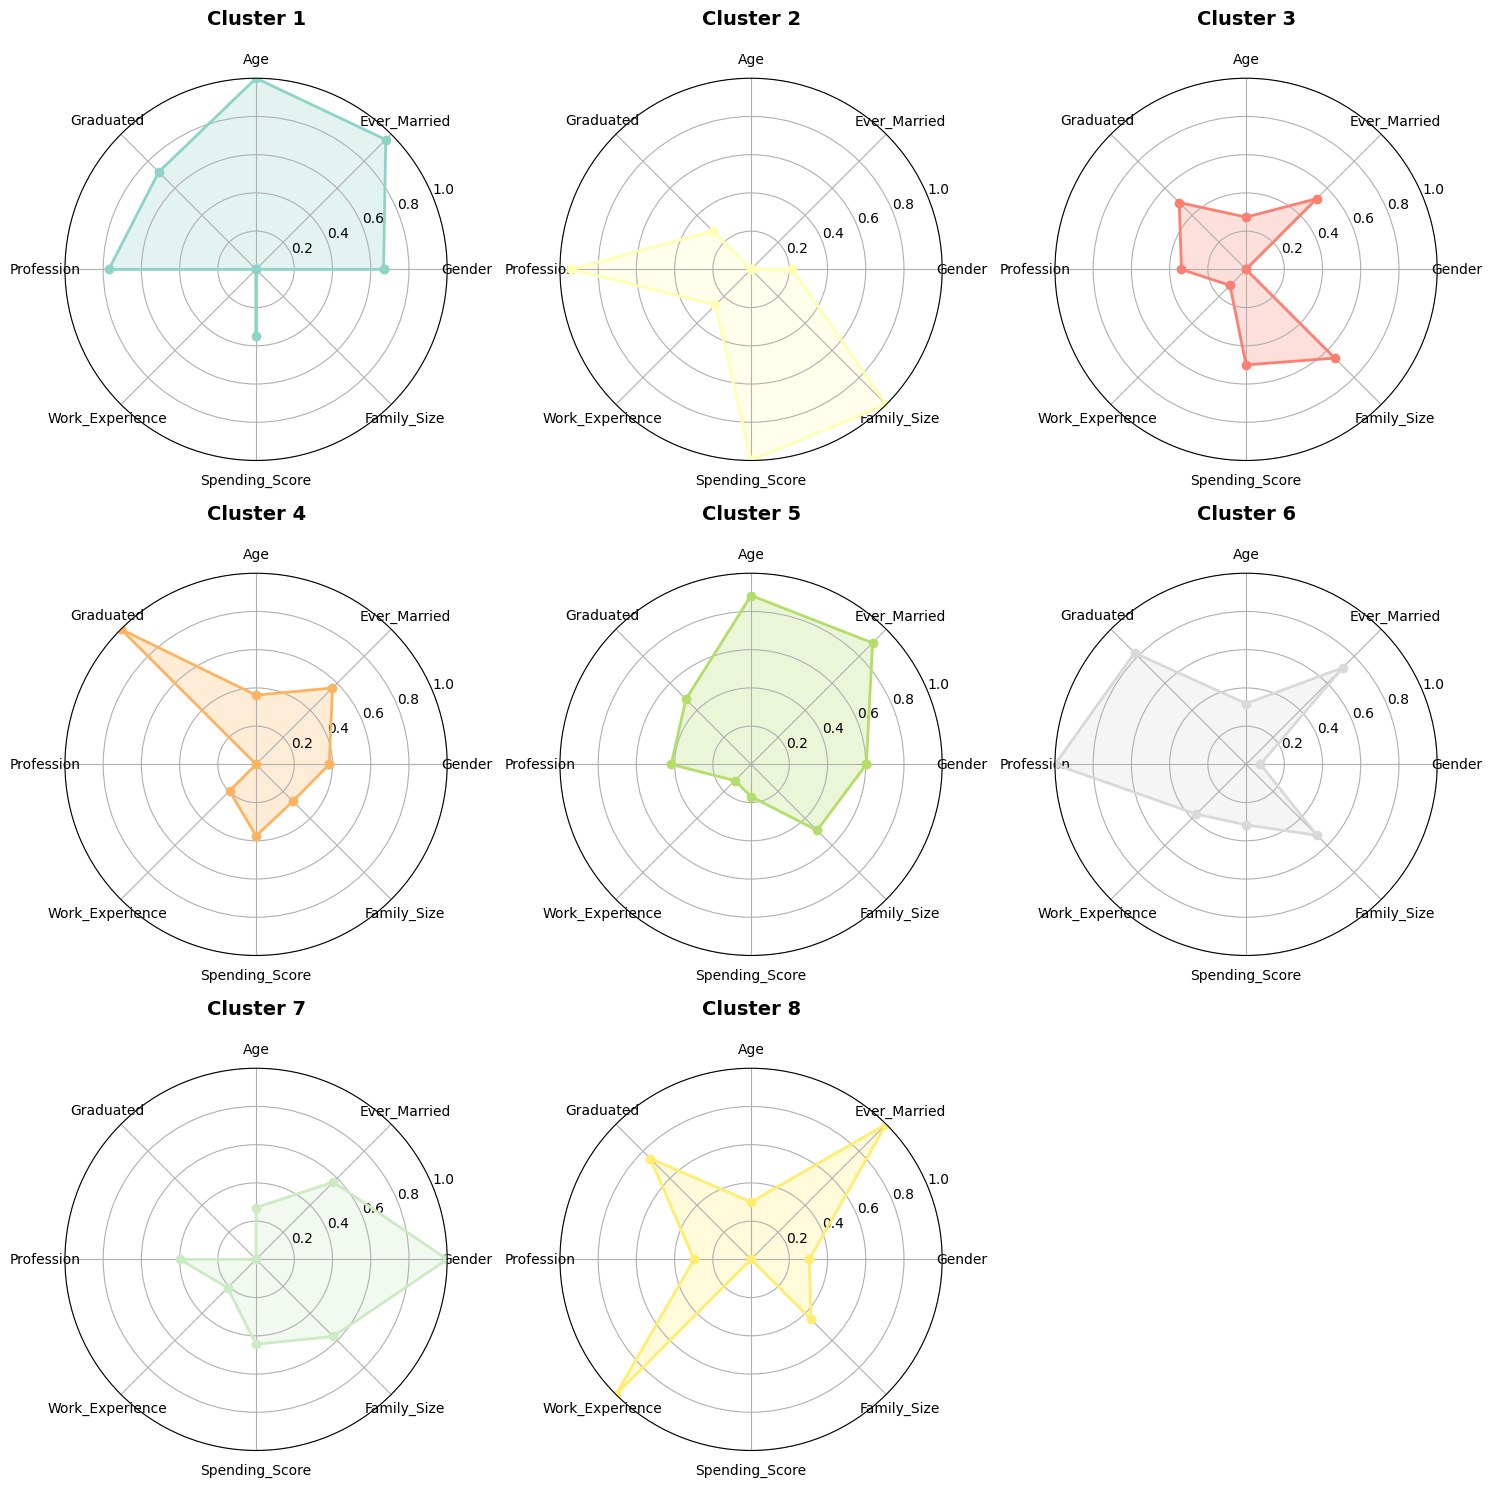

In [53]:
labels = dfclusFin.Cluster.unique()
df_with_clusters = dfclusFin.copy()
# df_with_clusters['Cluster'] = labels

# Select features for radial chart
numerical_cols = ['Gender', 'Ever_Married', 'Age', 'Graduated', 'Profession', 'Work_Experience', 'Spending_Score', 'Family_Size']
sample_features = numerical_cols#[:6]  # Limit to 6 features for readability

if not sample_features:
    print("No numerical features available for radial chart")

# Calculate means for each cluster
cluster_means = df_with_clusters.groupby('Cluster')[sample_features].mean()

# Normalize values to 0-1 scale for better visualization
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
normalized_means = pd.DataFrame(
    scaler.fit_transform(cluster_means),
    columns=cluster_means.columns,
    index=cluster_means.index
)

# Create radial charts with automatic grid layout
n_clusters = len(normalized_means)

# Calculate optimal grid dimensions
if n_clusters <= 3:
    n_rows, n_cols = 1, n_clusters
elif n_clusters <= 6:
    n_rows, n_cols = 2, (n_clusters + 1) // 2
elif n_clusters <= 9:
    n_rows, n_cols = 3, (n_clusters + 2) // 3
else:
    n_rows = int(np.ceil(np.sqrt(n_clusters)))
    n_cols = int(np.ceil(n_clusters / n_rows))

# Adjust figure size based on grid
fig_width = min(5 * n_cols, 20)  # Cap width at 20
fig_height = min(5 * n_rows, 15)  # Cap height at 15

fig, axes = plt.subplots(n_rows, n_cols, figsize=(fig_width, fig_height), 
                        subplot_kw=dict(projection='polar'))

# Handle different cases for axes array structure
if n_clusters == 1:
    axes = [axes]
elif n_rows == 1:
    axes = axes if n_cols > 1 else [axes]
else:
    axes = axes.flatten()

angles = np.linspace(0, 2*np.pi, len(sample_features), endpoint=False).tolist()
angles += angles[:1]  # Complete the circle

colors = plt.cm.Set3(np.linspace(0, 1, n_clusters))

for idx, (cluster_id, cluster_data) in enumerate(normalized_means.iterrows()):
    values = cluster_data.tolist()
    values += values[:1]  # Complete the circle
    
    ax = axes[idx]
    ax.plot(angles, values, 'o-', linewidth=2, color=colors[idx])
    ax.fill(angles, values, alpha=0.25, color=colors[idx])
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(sample_features)
    ax.set_ylim(0, 1)
    ax.set_title(f'Cluster {cluster_id}', size=14, weight='bold', pad=20)
    ax.grid(True)

# Hide unused subplots if any
total_subplots = n_rows * n_cols
if n_clusters < total_subplots:
    for i in range(n_clusters, total_subplots):
        axes[i].set_visible(False)

plt.tight_layout()
plt.show()

In [54]:
print(f"\n{'='*50}")
print(f"CLUSTER PROFILES ")
print(f"{'='*50}")

# Numerical features analysis
# if numerical_cols:
numerical_cols = ['Age', 'economic_capacity_index', 'family_responsibility_factor']
print("\nNumerical Features by Cluster:")
for col in numerical_cols:
    numerical_stats = df_with_clusters.groupby('Cluster')[col].agg(['mean', 'std'])
    print (col)
    print(numerical_stats.round(2))

# Categorical features analysis
categorical_cols = ['Gender', 'Ever_Married', 'Graduated', 'Profession','Work_Experience', 'Spending_Score', 'Family_Size',
                    'profession_category', 'life_stage', 'profession_education_match']
if categorical_cols:
    print("\nCategorical Features Distribution by Cluster:")
    for col in categorical_cols:
        print(f"\n{col.upper()}:")
        crosstab = pd.crosstab(df_with_clusters['Cluster'], 
                                df_with_clusters[col], normalize='index')
        print((crosstab * 100).round(1).to_string())


CLUSTER PROFILES 

Numerical Features by Cluster:
Age
          mean    std
Cluster              
1        72.67   8.92
2        26.14   6.02
3        38.86  10.32
4        42.98   9.06
5        67.24   7.94
6        40.94  10.74
7        38.74  10.39
8        40.10   5.33
economic_capacity_index
          mean    std
Cluster              
1        76.26  15.90
2        30.64  14.28
3        70.25  17.84
4        64.06   7.10
5        58.04  19.62
6        62.95  20.06
7        39.62  10.65
8        65.96  16.27
family_responsibility_factor
         mean   std
Cluster            
1        3.11  1.57
2        1.49  0.66
3        2.26  1.59
4        2.01  1.44
5        3.88  1.96
6        2.39  1.51
7        2.18  1.41
8        2.40  1.24

Categorical Features Distribution by Cluster:

GENDER:
Gender      0     1
Cluster            
1        41.1  58.9
2        47.2  52.8
3        50.1  49.9
4        44.9  55.1
5        42.0  58.0
6        49.1  50.9
7        36.6  63.4
8        46.0  5

In [55]:
# Filter out noise points
df_filtered = df_with_clusters[df_with_clusters['Cluster'] >= -1]

segment_names = {}

for cluster_id in sorted(df_filtered['Cluster'].unique()):
    cluster_data = df_filtered[df_filtered['Cluster'] == cluster_id]
    
    # Analyze key characteristics
    descriptors = []
    
    # Age-based descriptor
    if 'Age' in cluster_data.columns:
        avg_age = cluster_data['Age'].mean()
        if avg_age < 30:
            descriptors.append('Young')
        elif avg_age > 50:
            descriptors.append('Senior')
        else:
            descriptors.append('Mid Age')
    
    # Profession-based descriptor
    if 'profession_category' in cluster_data.columns:
        top_profession = cluster_data['profession_category'].mode().iloc[0] if not cluster_data['profession_category'].mode().empty else None
        if top_profession:
            if top_profession == 3:
                descriptors.append('Professionals')
            elif top_profession == 1:
                descriptors.append('Creatives')
            elif top_profession == 0:
                descriptors.append('Service Workers')
            elif top_profession == 2:
                descriptors.append('Business')
    
    # Spending-based descriptor
    spending_col = 'annual_spending' if 'annual_spending' in cluster_data.columns else 'Spending_Score'
    if spending_col == 'Spending_Score':
        top_spending = cluster_data[spending_col].mode().iloc[0] if not cluster_data[spending_col].mode().empty else None
        if top_spending == 1:
            descriptors.append('High Spenders')
        elif top_spending == 2:
            descriptors.append('Budget Conscious')
        elif top_spending == 0:
            descriptors.append('Average Spenders')

    # Marital status descriptor
    if 'Ever_Married' in cluster_data.columns:
        top_marital_status = cluster_data['Ever_Married'].mode().iloc[0] if not cluster_data['Ever_Married'].mode().empty else None
        if top_marital_status == 1:
            descriptors.append('Married')
        elif top_marital_status == 0:
            descriptors.append('Single')

    # Education descriptor
    if 'Graduated' in cluster_data.columns:
        top_education = cluster_data['Graduated'].mode().iloc[0] if not cluster_data['Graduated'].mode().empty else None
        if top_education == 1:
            descriptors.append('Educated')
        elif top_education == 0:
            descriptors.append('Non-Graduates')
    
    # Gender descriptor
    if 'Gender' in cluster_data.columns:
        top_gender = cluster_data['Gender'].mode().iloc[0] if not cluster_data['Gender'].mode().empty else None
        if top_gender == 1:
            descriptors.append('Males')
        elif top_gender == 0:
            descriptors.append('Females')
    
    # Family size descriptor
    if 'Family_Size' in cluster_data.columns:
        top_family_size = cluster_data['Family_Size'].mode().iloc[0] if not cluster_data['Family_Size'].mode().empty else None
        if top_family_size <= 2:
            descriptors.append('Small Families')
        elif (top_family_size > 2) and (top_family_size <= 5):
            descriptors.append(f'Medium Families')
        elif top_family_size > 5:
            descriptors.append('Large Families')

    # Work experience descriptor
    if 'Work_Experience' in cluster_data.columns:
        top_experience = cluster_data['Work_Experience'].mode().iloc[0] if not cluster_data['Work_Experience'].mode().empty else None
        if top_experience <= 5:
            descriptors.append('Early Career')
        elif top_experience <= 12:
            descriptors.append('Mid Career')
        else:
            descriptors.append('Experienced')

    # Generate name
    if len(descriptors) >= 2:
        name = ' '.join(descriptors)
    elif len(descriptors) == 1:
        name = descriptors[0]
    else:
        name = f'Segment {cluster_id}'
    
    segment_names[cluster_id] = name

print(f"\n🏷️  SUGGESTED SEGMENT NAMES - ")
print("-" * 50)
for cluster_id, name in segment_names.items():
    cluster_size = len(df_filtered[df_filtered['Cluster'] == cluster_id])
    pct = cluster_size / len(df_filtered) * 100
    print(f"Cluster {cluster_id}: '{name}' ({cluster_size} customers, {pct:.1f}%)")



🏷️  SUGGESTED SEGMENT NAMES - 
--------------------------------------------------
Cluster 1: 'Senior Business High Spenders Married Educated Males Small Families Early Career' (1219 customers, 14.6%)
Cluster 2: 'Young Professionals Budget Conscious Single Non-Graduates Males Medium Families Early Career' (1519 customers, 18.2%)
Cluster 3: 'Mid Age Business Budget Conscious Married Educated Females Small Families Early Career' (1514 customers, 18.1%)
Cluster 4: 'Mid Age Creatives Budget Conscious Married Educated Males Small Families Early Career' (2127 customers, 25.4%)
Cluster 5: 'Senior Creatives Budget Conscious Married Non-Graduates Males Small Families Early Career' (336 customers, 4.0%)
Cluster 6: 'Mid Age Professionals Budget Conscious Married Educated Males Small Families Early Career' (281 customers, 3.4%)
Cluster 7: 'Mid Age Creatives Budget Conscious Married Non-Graduates Males Small Families Early Career' (604 customers, 7.2%)
Cluster 8: 'Mid Age Creatives Average Spenders